# Program Equivalence Condensed 

# Imports

In [1]:
from openai import OpenAI
import json
import os
import re
import random
import pandas as pd
from src.paths import DATA_DIR
from src.models import gpt_4o, gpt_4o_mini, preview_o1

# Ensure dataframe has max with
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Load the API key from environment variables
api_key = os.getenv("OPENAI_API_KEY")
openai = OpenAI(api_key=api_key)

%load_ext autoreload
%autoreload 2


In [40]:
# Define paths 
llm_exp_path = os.path.join("..", "program_data", "llm_exp_train_df_program.csv")
few_shot_path = os.path.join("..", "program_data", "few_shot_program.csv")
train_df_path = os.path.join("..", "program_data", "train_df_program.csv")

In [3]:
import pandas as pd

# Load the datasets
file_paths = {
    "Few_Shot_Prompt": few_shot_path,
    "Basic_Prompt": train_df_path
}

# Load each dataset into a dictionary of dataframes
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}
# dataframes



# Overview of different techniques and how they performed

In [44]:
# Display basic information about each dataset
df_info = {}
for name, df in dataframes.items():
    df_info[name] = {
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Missing Values": df.isnull().sum().sum(),
        "Program Equivalence %": df['program_equivalence'].mean() * 100 if 'program_equivalence' in df.columns else "N/A",
    }

# Convert the summary into a DataFrame for visualization
df_summary = pd.DataFrame.from_dict(df_info, orient="index")

# Display the dataset summary to the user
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Dataset Overview", dataframe=df_summary)

Dataset Overview


# Errors by category

program_error_category
Missing or Extra Computation Steps       63
Incorrect Mathematical Operation         19
Variable Reference Error                 10
Reordering Without Preserving Meaning     7
Misinterpretation of Constants            1
Name: count, dtype: int64


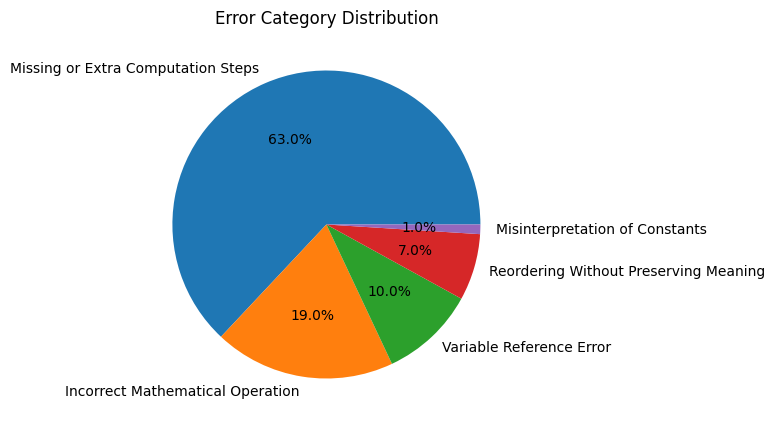

In [41]:
llm_exp = pd.read_csv(llm_exp_path)
# llm_exp.head()

# Suppose your DataFrame is named 'df'
# and has a column called 'answer_error_category'

# 1. Count per category
category_counts = llm_exp['program_error_category'].value_counts(dropna=False)
print(category_counts)



# 2. Pie chart
plt.figure(figsize=(5, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Error Category Distribution')
plt.ylabel('')  # hide the default label
plt.show()

# Looking at individual errors per prompt technique

Misclassified Program Predictions - Few_Shot_Prompt


Misclassified Program Predictions - Basic_Prompt


Misclassified Program Counts per Dataset


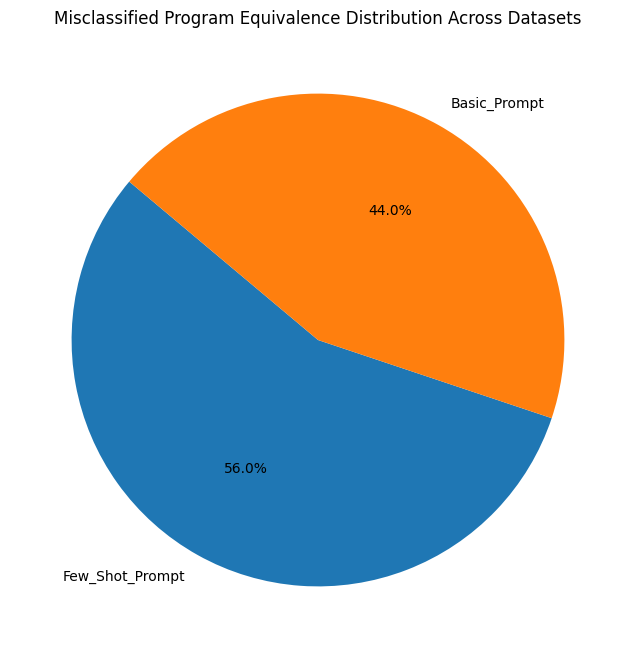

In [31]:
# Analyze misclassified examples where Program Equivalence is False
misclassified_program_dfs = {}

for name, df in dataframes.items():
    if 'program_equivalence' in df.columns:
        misclassified_program_dfs[name] = df[df['program_equivalence'] == 0][['question', 'program', 'model_program_prediction', 'program_equivalence']]

# Display the misclassified examples
for name, misclassified_df in misclassified_program_dfs.items():
    if not misclassified_df.empty:
        tools.display_dataframe_to_user(name=f"Misclassified Program Predictions - {name}", dataframe=misclassified_df)

# Visualization: Count of misclassified program predictions per dataset
misclassified_program_counts = {name: len(df) for name, df in misclassified_program_dfs.items()}
misclassified_program_df = pd.DataFrame.from_dict(misclassified_program_counts, orient="index", columns=["Misclassified Program Count"])

# Display as table
tools.display_dataframe_to_user(name="Misclassified Program Counts per Dataset", dataframe=misclassified_program_df)

# Pie Chart for Misclassification Rates in Program Equivalence
plt.figure(figsize=(8, 8))
plt.pie(misclassified_program_df["Misclassified Program Count"], labels=misclassified_program_df.index, autopct='%1.1f%%', startangle=140)
plt.title("Misclassified Program Equivalence Distribution Across Datasets")
plt.show()



# Performance accross datasets barchart viz

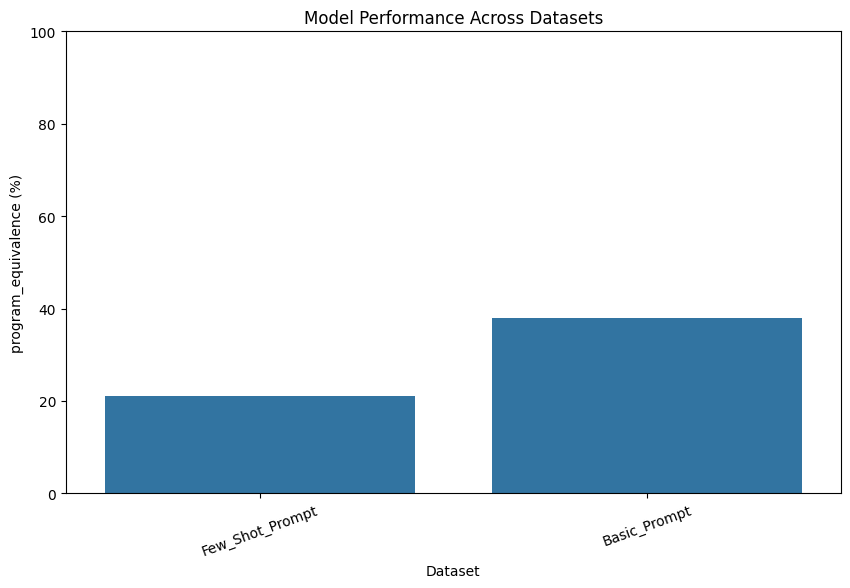

Misclassified Counts per Dataset


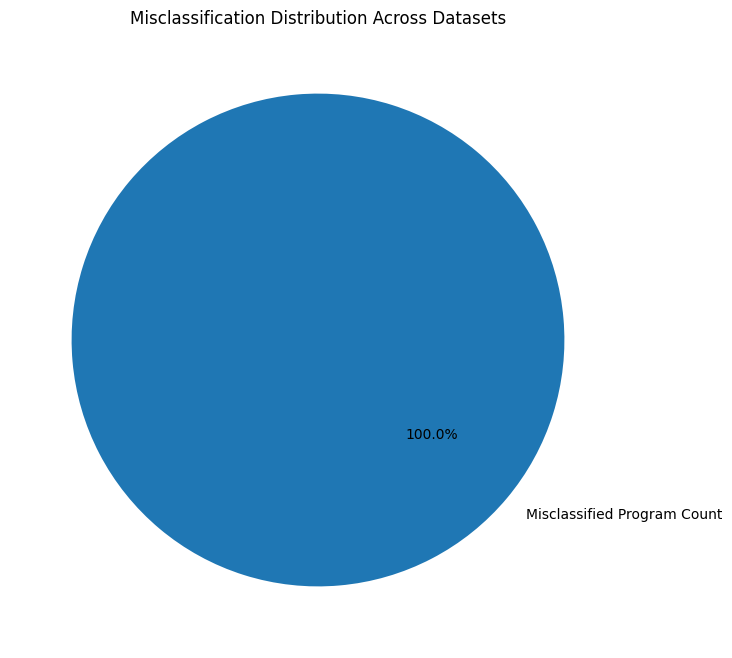

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Bar chart of Answer Exact Match % across datasets
plt.figure(figsize=(10, 6))
sns.barplot(x=df_summary.index, y=df_summary["Program Equivalence %"])
plt.xlabel("Dataset")
plt.ylabel("program_equivalence (%)")
plt.title("Model Performance Across Datasets")
plt.xticks(rotation=20)
plt.ylim(0, 100)
plt.show()

# Visualization: Count of misclassified examples per dataset
misclassified_counts = {name: len(df) for name, df in misclassified_program_df.items()}
misclassified_program_df = pd.DataFrame.from_dict(misclassified_counts, orient="index", columns=["Misclassified Count"])

tools.display_dataframe_to_user(name="Misclassified Counts per Dataset", dataframe=misclassified_program_df)

# Pie Chart for Misclassification Rates
plt.figure(figsize=(8, 8))
plt.pie(misclassified_program_df["Misclassified Count"], labels=misclassified_program_df.index, autopct='%1.1f%%', startangle=140)
plt.title("Misclassification Distribution Across Datasets")
plt.show()
